In [162]:
from PID import PID
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

In [163]:
pid = PID(Kp=100.0, Ki=0.0, Kd=10000.0, sample_time=0.1).compute
DRAG_COEFF = 1
DRAG_ON = False
MASS = 18.0
SETPOINT = -0.5
TIME_SPAN = [0, 20]
z_0 = np.array([-0.5, -.5,])

In [164]:
def f(t, z):
    vel = z[1]
    drag = (DRAG_COEFF/MASS)*(z[1]**2)
    acc = (1/MASS)*pid(SETPOINT, z[0])
    if DRAG_ON:
        acc += drag
    return np.array([vel, acc])

In [165]:
soln = solve_ivp(f, TIME_SPAN, z_0)

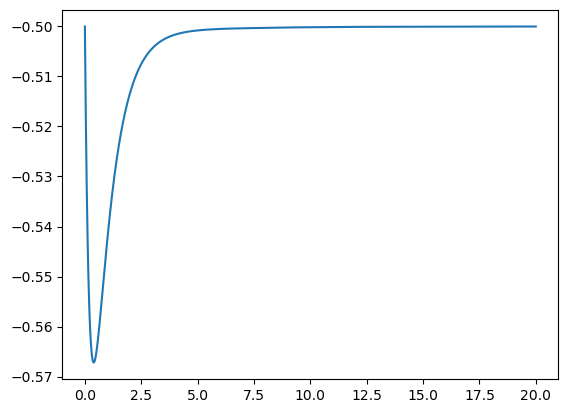

In [166]:
plt.plot(soln.t, soln.y[0])